In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import stats     # 이상치 처리를 위해서 필요
from sklearn import linear_model  # sklearn으로 simple linear regression 구현
from sklearn.preprocessing import MinMaxScaler # normalization 전처리

# 데이터 전처리
# 데이터 가져오기
df = pd.read_csv('./data/ozone.csv')
# display(df)
data = df[['Temp','Ozone']]
# display(data)  # 153 rows × 6 columns

# 결측치 처리
train_data = data.dropna(how='any')
# display(training_data)  # 116 rows × 2 columns

# 이상치 처리
# z-score
zscore_threshold = 1.8

# Temp에 대한 이상치 처리
tmp = ~(np.abs(stats.zscore(train_data['Temp'])) > zscore_threshold)
train_data = train_data.loc[tmp]  
# display(training_data)  # 110 rows × 2 columns

# Ozone에 대한 이상치 처리
tmp = ~(np.abs(stats.zscore(train_data['Ozone'])) > zscore_threshold)
train_data = train_data.loc[tmp]
# display(training_data)  # 103 rows × 2 columns


# training data set
train_x_data = train_data['Temp'].values.reshape(-1,1)
train_t_data = train_data['Ozone'].values.reshape(-1,1)

# 정규화 처리
scaler_x = MinMaxScaler() 
scaler_t = MinMaxScaler() 
scaler_x.fit(train_x_data)
scaler_t.fit(train_t_data)

train_x_data_norm = scaler_x.transform(train_x_data)
train_t_data_norm = scaler_t.transform(train_t_data)



In [3]:
# Python으로 구현

# Weight & bias
W_p  = np.random.rand(1,1)
b_p  = np.random.rand(1)

# 3. Hypothesis
def predict(x):
    y = np.dot(x,W_p) + b_p  # y = x dot W + b
    return y

# 4. loss function
def loss_func(input_obj):
    # input_obj : [W, b]
    input_W = input_obj[0]
    input_b = input_obj[1]
    
    y = np.dot(train_x_data_norm, input_W) + input_b  
    return np.mean(np.power((train_t_data_norm - y),2)) 

# 5. 편미분을 위한 함수
def numerical_derivative(f,x):
  
    delta_x = 1e-4
    derivative_x = np.zeros_like(x)   
    
    it = np.nditer(x, flags=['multi_index'])  
    
    while not it.finished:
        
        idx = it.multi_index  
        temp = x[idx]  
        
        x[idx] = temp + delta_x
        fx_plus_delta = f(x)   
        
        x[idx] = temp - delta_x
        fx_minus_delta = f(x)  
        
        derivative_x[idx] = (fx_plus_delta - fx_minus_delta) / (2 * delta_x)
        
        x[idx] = temp 
        
        it.iternext()
        
    return derivative_x

# learning rate 설정
learning_rate = 1e-4


for step in range(300000):
    input_param = np.concatenate((W_p.ravel(), b_p.ravel()), axis=0)
    derivative_result = learning_rate * numerical_derivative(loss_func, input_param)
    
    # W,b를 갱신
    W_p = W_p - derivative_result[:1].reshape(1,1)
    b_p = b_p - derivative_result[1:]
    
    if step % 30000 ==0:
        print('W : {}, b : {}'.format(W_p,b_p))

W : [[0.91343668]], b : [0.32185641]
W : [[0.74987006]], b : [-0.02400962]
W : [[0.76190586]], b : [-0.03065596]
W : [[0.77075611]], b : [-0.03538796]
W : [[0.77721685]], b : [-0.03884229]
W : [[0.78193322]], b : [-0.04136395]
W : [[0.78537618]], b : [-0.04320478]
W : [[0.78788956]], b : [-0.04454859]
W : [[0.78972434]], b : [-0.04552958]
W : [[0.79106373]], b : [-0.0462457]


In [5]:
# Tensorflow로 구현

# # Training Data Set
# x_data = training_data['Temp'].values.reshape(-1,1)
# t_data = training_data['Ozone'].values.reshape(-1,1)

# placeholder
X = tf.placeholder(shape=[None,1], dtype=tf.float32)
T = tf.placeholder(shape=[None,1], dtype=tf.float32)

# Weight & bias
W = tf.Variable(tf.random.normal([1,1]), name='weight')
b = tf.Variable(tf.random.normal([1]), name='bias')

# Hypothesis
H = tf.matmul(X,W) + b

# loss function
loss = tf.reduce_mean(tf.square(H-T))

# train
train = tf.train.GradientDescentOptimizer(learning_rate=1e-4).minimize(loss)

# session, 초기화
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(300000):
    _, W_val, b_val, loss_val = sess.run([train, W, b, loss], 
                                         feed_dict={X: train_x_data_norm, T: train_t_data_norm})
    
    if step % 30000 == 0:
        print('W : {}, b : {}, loss : {}'.format(W_val,b_val,loss_val))

W : [[2.817478]], b : [-0.6688451], loss : 0.46649810671806335
W : [[2.1315737]], b : [-0.762737], loss : 0.15085379779338837
W : [[1.770579]], b : [-0.56995696], loss : 0.09456026554107666
W : [[1.507111]], b : [-0.42909116], loss : 0.06455910950899124
W : [[1.3147902]], b : [-0.32626134], loss : 0.048571545630693436
W : [[1.1743879]], b : [-0.25119808], loss : 0.040050867944955826
W : [[1.0719126]], b : [-0.19640715], loss : 0.035510431975126266
W : [[0.9971471]], b : [-0.1564218], loss : 0.033091407269239426
W : [[0.94251645]], b : [-0.12721486], loss : 0.03180075064301491
W : [[0.9026386]], b : [-0.10589216], loss : 0.031112803146243095


In [4]:
# Sklearn으로 구현해서 확인하기

model = linear_model.LinearRegression()
model.fit(train_x_data,train_t_data)

print('W : {}, b : {}'.format(model.coef_, model.intercept_))

W : [[2.23956713]], b : [-137.09451328]


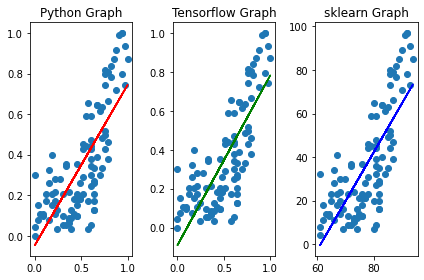

In [7]:
# Graph로 비교해 보기
fig = plt.figure()
fig_python = fig.add_subplot(1,3,1)
fig_tensorflow = fig.add_subplot(1,3,2)
fig_sklearn = fig.add_subplot(1,3,3)

# set title
fig_python.set_title('Python Graph')
fig_tensorflow.set_title('Tensorflow Graph')
fig_sklearn.set_title('sklearn Graph')

# python graph
fig_python.scatter(train_x_data_norm,train_t_data_norm)
fig_python.plot(train_x_data_norm,train_x_data_norm*W_p + b_p, color='r')

# Tensorflow Graph
fig_tensorflow.scatter(train_x_data_norm,train_t_data_norm)
fig_tensorflow.plot(train_x_data_norm,train_x_data_norm*W_val + b_val, color='g')

# sklearn Graph
fig_sklearn.scatter(train_x_data,train_t_data)
fig_sklearn.plot(train_x_data,train_x_data*model.coef_ + model.intercept_, color='b')

# Graph
fig.tight_layout()
plt.show()



In [31]:
# prediction
# 온도가 62도 일때 Ozone은 얼마일까요??
predict_data = np.array([[62]])

# 예측할 값 정규화
scaled_predict_data = scaler_x.transform(predict_data)

# tensorflow를 이용
tensorflow_result = sess.run(H, feed_dict={X:scaled_predict_data})
tensorflow_result = scaler_t.inverse_transform(tensorflow_result)
print('tensorflow : {}'.format(tensorflow_result))


# sklearn을 이용
model = linear_model.LinearRegression()
model.fit(train_x_data,train_t_data)
sklearn_result = model.predict([[62]])
print('sklearn : {}'.format(sklearn_result))    


# python을 이용
python_result = predict(scaled_predict_data)
python_result = scaler_t.inverse_transform(python_result)
print('python : {}'.format(python_result))

tensorflow : [[-1.9391316]]
sklearn : [[1.75864872]]
python : [[1.88265042]]
